In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from collections import Counter
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.util import ngrams
import nltk

nltk.download("stopwords")
nltk.download('punkt_tab')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/izlaster/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/izlaster/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [2]:
stop_words = set(stopwords.words("russian"))
TEXT_FILES_DIR = "garant"

## Функция для загрузки текстов

In [3]:
def load_texts_from_folder(folder_path):
    texts = []
    filenames = []
    for file in tqdm(sorted(os.listdir(folder_path)), desc="Загрузка текстов"):
        if file.endswith(".txt"):
            file_path = os.path.join(folder_path, file)
            with open(file_path, "r", encoding="utf-8") as f:
                text = f.read().strip()
                texts.append(text)
                filenames.append(file)
    return texts, filenames

In [4]:
texts, filenames = load_texts_from_folder(TEXT_FILES_DIR)

Загрузка текстов: 100%|████████████████████████████████████████████████████████████| 1629/1629 [00:02<00:00, 700.57it/s]


## Создаём DataFrame для анализа


In [5]:
df = pd.DataFrame({"filename": filenames, "text": texts})
df["text_length"] = df["text"].apply(len)

## Статистика текстов

In [6]:
print(f"Всего текстов: {len(texts)}")
print(f"Средняя длина текста: {df['text_length'].mean():.2f} символов")
print(f"Самый длинный текст: {df['text_length'].max()} символов")
print(f"Самый короткий текст: {df['text_length'].min()} символов")

Всего текстов: 1629
Средняя длина текста: 17945.92 символов
Самый длинный текст: 247590 символов
Самый короткий текст: 368 символов


## Гистограмма длины текстов


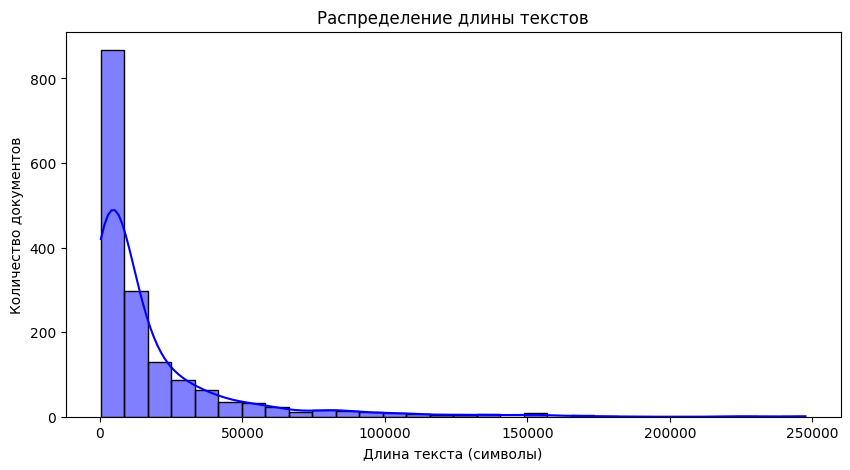

In [7]:
plt.figure(figsize=(10, 5))
sns.histplot(df["text_length"], bins=30, kde=True, color="blue")
plt.xlabel("Длина текста (символы)")
plt.ylabel("Количество документов")
plt.title("Распределение длины текстов")
plt.show()

## Функция для токенизации и удаления стоп-слов


In [8]:
def tokenize_text(text):
    words = nltk.word_tokenize(text.lower())
    words = [w for w in words if w.isalpha() and w not in stop_words]
    return words

## Объединяем все тексты и анализируем частоту слов


In [9]:
all_words = []
for text in texts:
    all_words.extend(tokenize_text(text))

word_freq = Counter(all_words)
top_words = word_freq.most_common(20)  # Топ-20 слов

## Таблица частотности слов


In [10]:
df_words = pd.DataFrame(top_words, columns=["Слово", "Частота"])
df_words

,Слово,Частота
0,области,19570
1,n,17184
2,федерации,9931
3,российской,9909
4,города,6804
5,года,6175
6,республики,5522
7,средств,5480
8,соответствии,5055
9,государственной,4830


## Собираем биграммы и триграммы


In [11]:
def get_ngrams(text, n):
    words = tokenize_text(text)
    return list(ngrams(words, n))

In [12]:
bi_grams = Counter()
tri_grams = Counter()

for text in texts:
    bi_grams.update(get_ngrams(text, 2))
    tri_grams.update(get_ngrams(text, 3))

## Выводим 10 самых популярных биграмм

In [13]:
print("Топ-10 биграмм:")
for phrase, freq in bi_grams.most_common(10):
    print(" ".join(phrase), "-", freq)

Топ-10 биграмм:
российской федерации - 9597
местного самоуправления - 2423
республики татарстан - 2250
ленинградской области - 2114
года n - 2077
государственной власти - 1661
чувашской республики - 1604
автономного округа - 1576
исполнительной власти - 1499
согласно приложению - 1288


## Выводим 10 самых популярных триграмм

In [14]:
print("Топ-10 триграмм:")
for phrase, freq in tri_grams.most_common(10):
    print(" ".join(phrase), "-", freq)

Топ-10 триграмм:
законодательством российской федерации - 918
российской федерации n - 835
согласно приложению n - 788
правительства российской федерации - 736
органов государственной власти - 722
ст n ст - 670
органов местного самоуправления - 668
n ст n - 659
n внесении изменений - 596
изложить следующей редакции - 582


## Получаем топ-10 слов по TF-IDF

In [15]:
vectorizer = TfidfVectorizer(max_features=50, stop_words=list(stop_words), ngram_range=(1, 2))
tfidf_matrix = vectorizer.fit_transform(texts)

feature_names = vectorizer.get_feature_names_out()
top_tfidf = np.argsort(tfidf_matrix.toarray().sum(axis=0))[-10:][::-1]
print("Топ-10 ключевых слов по TF-IDF:")
for i in top_tfidf:
    print(feature_names[i])

Топ-10 ключевых слов по TF-IDF:
области
2004
федерации
российской
российской федерации
города
республики
года
администрации
статья
